# Approximation
1. by Taylor series: 
    works good at the x=x0 center, becomes worse as x further away from the center
    error is biased for some cases
2. by Chebyshev polynomials
    has fast approximation transform due to FFT O(N*log(N)), higher order means more colocations
3. by least squares or generic convex optimization:
    * arbitrary function basis can be used. 
    * usually approximation complexity is higher, but not a problem for offline function approximation
    * least squares fits are similar to Chebyshev approximation
    * the min(max()) problem formed as minimal ripple amplitude gives the most satisfactory results

('Taylor expansion at n=1', x)
('Taylor expansion at n=3', x**3/3 - x**2/2 + x)
('Taylor expansion at n=5', x**5/5 - x**4/4 + x**3/3 - x**2/2 + x)
('Taylor expansion at n=7', x**7/7 - x**6/6 + x**5/5 - x**4/4 + x**3/3 - x**2/2 + x)
('Taylor expansion at n=9', x**9/9 - x**8/8 + x**7/7 - x**6/6 + x**5/5 - x**4/4 + x**3/3 - x**2/2 + x)


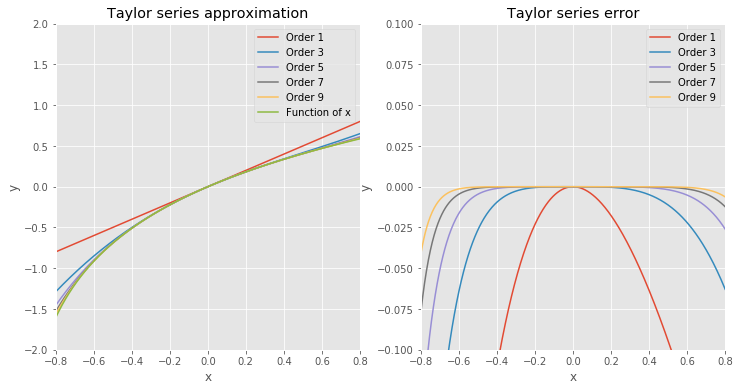

In [101]:
%matplotlib inline

import sympy as sy
import numpy as np
from sympy.functions import sin, cos, ln
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.style.use("ggplot")

# Factorial function
def factorial(n):
    if n <= 0:
        return 1
    else:
        return n * factorial(n - 1)

# Taylor approximation at x0 of the function 'function'
def taylor(function, x0, n, x = sy.Symbol('x')):
    i = 0
    p = 0
    while i <= n:
        p = p + (function.diff(x, i).subs(x, x0))/(factorial(i))*(x - x0)**i
        i += 1
    return p

def plot(f, x0 = 0, n = 9, by = 2, x_lims = [-5, 5], y_lims = [-2, 2], npoints = 800, x = sy.Symbol('x')):
    x1 = np.linspace(x_lims[0], x_lims[1], npoints)
    func_lambda = sy.lambdify(x, f, "numpy")
    y1 = func_lambda(x1)
    
    # Approximate up until n starting from 1 and using steps of by
    taylor_lambda_list=[]
    for j in range(1, n + 1, by):
        func = taylor(f, x0, j)
        taylor_lambda = sy.lambdify(x, func, "numpy")
        print('Taylor expansion at n=' + str(j), func)
        taylor_lambda_list.append((j,taylor_lambda))
        
    plt.subplot(121)
    for (j,taylor_lambda) in taylor_lambda_list:
        plt.plot(x1, taylor_lambda(x1), label = 'Order '+ str(j))
    # Plot the function to approximate (sine, in this case)
    plt.plot(x1, y1, label = 'Function of x')
    
    plt.xlim(x_lims)
    plt.ylim(y_lims)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.title('Taylor series approximation')
    
    plt.subplot(122)
    y_lims = [-0.1, 0.1]
    for (j,taylor_lambda) in taylor_lambda_list:
        plt.plot(x1, y1 - taylor_lambda(x1), label = 'Order '+ str(j))
    # Plot the function to approximate (sine, in this case)
    plt.xlim(x_lims)
    plt.ylim(y_lims)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.title('Taylor series error')
    
    plt.show()

# Define the variable and the function to approximate
x = sy.Symbol('x')
f = ln(1 + x)
plot(f, x_lims=[-0.8,0.8])

##########################################################################
#                           OUTPUT
##########################################################################
#
# RuntimeWarning: invalid value encountered in log
#
# Taylor expansion at n=1 x
# Taylor expansion at n=3 x**3/3 - x**2/2 + x
# Taylor expansion at n=5 x**5/5 - x**4/4 + x**3/3 - x**2/2 + x
# Taylor expansion at n=7 x**7/7 - x**6/6 + x**5/5 - x**4/4 + x**3/3 - x**2/2 + x
# Taylor expansion at n=9 x**9/9 - x**8/8 + x**7/7 - x**6/6 + x**5/5 - x**4/4 + x**3/3 - x**2/2 + x

Chebyshev coefficients: [-0.4462696645445107, 0.9999771516218322, -0.24995740375548373, 0.08324365976254924, -0.031054268626162434, 0.012065781821369128, -0.004231697142933429]


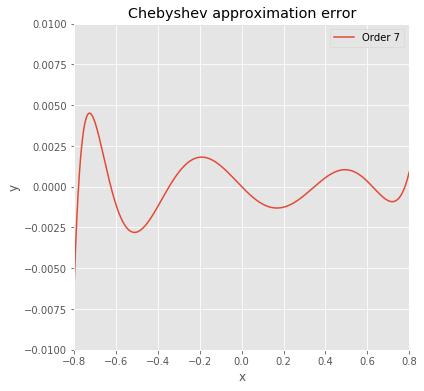

In [76]:

#http://excamera.com/sphinx/article-chebyshev.html
import math
class Chebyshev:
    """
    Chebyshev(a, b, n, func)
    Given a function func, lower and upper limits of the interval [a,b],
    and maximum degree n, this class computes a Chebyshev approximation
    of the function.
    Method eval(x) yields the approximated function value.
    """
    def __init__(self, a, b, n, func):
        self.a = a
        self.b = b
        self.func = func
        bma = 0.5 * (b - a)
        bpa = 0.5 * (b + a)
        # f(x) x in [a,b]
        # y=(2x-(b+a))/(b-a) in [-1,1]
        # x=y*0.5*(b-a)+0.5*(b+a)
        # f(y*0.5*(b-a)+0.5*(b+a)) is the g(y) with y in [-1,1]
        # Chebyshev polynomial 
        f = [func(math.cos(math.pi * (k + 0.5) / n) * bma + bpa) for k in range(n)]
        fac = 2.0 / n
        self.c = [fac * sum([f[k] * math.cos(math.pi * j * (k + 0.5) / n)
                  for k in range(n)]) for j in range(n)]
    def eval(self, x):
        a,b = self.a, self.b
        assert(a <= x <= b)
        y = (2.0 * x - a - b) * (1.0 / (b - a)) # x in [a,b] => y in [-1,1]
        y2 = 2.0 * y
        (d, dd) = (self.c[-1], 0)             # Special case first step for efficiency
        for cj in self.c[-2:0:-1]:            # Clenshaw's recurrence
            #d = y2 * d - dd + cj
            #dd = d
            (d, dd) = (y2 * d - dd + cj, d)
        return y * d - dd + 0.5 * self.c[0]   # Last step is different
    
def plot2(f, x0 = 0, n = 9, by = 2, x_lims = [-0.9999999, 1], y_lims = [-0.01, 0.01], npoints = 800, x = sy.Symbol('x')):
    x1 = np.linspace(x_lims[0], x_lims[1], npoints)
    func_lambda = sy.lambdify(x, f, "numpy")
    y1 = func_lambda(x1)
    
    plt.figure(figsize=(6, 6))
    plt.subplot(111)
    
    j = 7
    c = Chebyshev(x_lims[0], x_lims[1], j, func_lambda)
    
    y2 = []
    for elex in x1:
        y2.append(c.eval(elex))
    
    print("Chebyshev coefficients: {}".format(c.c))
    
    plt.plot(x1, y1 - y2, label = 'Order '+ str(j))
    # Plot the function to approximate (sine, in this case)
    plt.xlim(x_lims)
    plt.ylim(y_lims)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    plt.title('Chebyshev approximation error')
    plt.show()
    
plot2(f, x_lims=[-0.8,0.8])


least squares approximation results
[-5.71058878e-01  5.50381872e-01 -5.38492539e-02  2.02925419e-01
 -5.26305645e-01  1.01054661e+00  5.11773323e-04]
`xtol` termination condition is satisfied.
Primal Feasibility  Dual Feasibility    Duality Gap         Step             Path Parameter      Objective          
1.0                 1.0                 1.0                 -                1.0                 1.0                 
0.3546990749541     0.3546990749541     0.3546990749541     0.6533490072452  0.3546990749541     0.7008894949266     
0.2373765487507     0.2373765487507     0.2373765487507     0.35131711119    0.2373765487507     0.1438999783426     
0.2098778835927     0.2098778835681     0.2098778835681     0.1254626781413  0.2098778835681     0.02862443944878    
0.1783643450154     0.178364345005      0.178364345005      0.1634352813661  0.178364345005      0.008659493834343   
0.1056484834226     0.1056484834255     0.1056484834255     0.4464055499561  0.1056484834255     0.

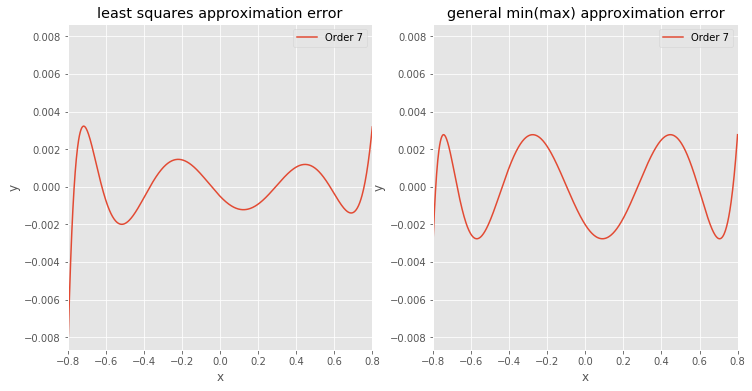

In [102]:
from scipy.optimize import least_squares
from scipy.optimize import linprog

def fun_model_poly(c, x):
    # c is the coefficients of    Cj*(x**j)
    y = x * 0 + c[0]
    for cj in c[1:]:
        y = np.multiply(y, x) + cj
    return y
    
def fun_residual(c, x1, y1):
    return y1 - fun_model_poly(c, x1)  # the residual error to be minimized

def plot3(f, x0 = 0, n = 9, by = 2, x_lims = [-0.9999999, 1], y_lims = [-0.04, 0.04], npoints = 800, x = sy.Symbol('x')):
    x1 = np.linspace(x_lims[0], x_lims[1], npoints)
    func_lambda = sy.lambdify(x, f, "numpy")
    y1 = func_lambda(x1)
    
    trainx = np.linspace(x_lims[0], x_lims[1], npoints)
    #trainx = np.interp(np.cos(np.linspace(0, np.pi, npoints)), [-1,1], x_lims)
    trainy = func_lambda(trainx)
    
    j = 7
    
    plt.figure(figsize=(12, 6))
    
    res_1 = least_squares(fun_residual, np.ones(j), args=(trainx, trainy))
    y2 = fun_model_poly(res_1.x, x1)
    print("least squares approximation results")
    print(res_1.x)
    print(res_1.message)
    
    ydiffmax = np.amax(np.abs(y1-y2))
    y_lims = [-ydiffmax, ydiffmax]
    
    plt.subplot(121)
    plt.plot(x1, y1 - y2, label = 'Order '+ str(j))
    # Plot the function to approximate (sine, in this case)
    plt.xlim(x_lims);    plt.ylim(y_lims);    plt.xlabel('x');    plt.ylabel('y');
    plt.legend();    plt.grid(True);    plt.title('least squares approximation error');
        
    # now try minimize the max error using LP
    #   minimize  max|sum(ck*(xi**k)) - yi|
    #
    # equivalent to:
    #
    #   minimize  t
    #   subject to    |sum(ck*(xi**k)) - yi|<t
    #     i.e.        sum(ck*(xi**k))-t < yi,
    #                -sum(ck*(xi**k))-t < -yi
    
    A_ub = np.zeros(shape=(npoints*2, j+1))
    b_ub = np.zeros(shape=(npoints*2, 1))
    for i in range(npoints):
        x_cur = trainx[i]
        y_cur = trainy[i]
        for k in range(j):
            A_ub[2*i+0,k] =  x_cur**k
            A_ub[2*i+1,k] = -x_cur**k
        A_ub[2*i+0,-1] = -1
        A_ub[2*i+1,-1] = -1
        b_ub[2*i+0] = y_cur
        b_ub[2*i+1] = -y_cur
        
    c = np.zeros(shape=(j+1))
    c[-1] = 1
    
    bounds=[(None, None) for i in range(j)]
    bounds.append((0,None))
    res_2 = linprog(c, A_ub, b_ub, method="interior-point", bounds=bounds, options={"maxiter":20, "disp":True})
    c = res_2.x
    
    print("general min(max) approximation: ")
    print(res_2)
    
    y2 = x1*0
    xtok = x1*0 + 1
    for k in range(j):
        y2 = y2 + c[k]*xtok
        xtok = np.multiply(xtok, x1)
    
    plt.subplot(122)
    plt.plot(x1, y1 - y2, label = 'Order '+ str(j))
    # Plot the function to approximate (sine, in this case)
    plt.xlim(x_lims);    plt.ylim(y_lims);    plt.xlabel('x');    plt.ylabel('y');
    plt.legend();    plt.grid(True);    plt.title('general min(max) approximation error');
    plt.show()
    
    
plot3(f, x_lims=[-0.8,0.8])